In [ ]:
# This script, create clusters of a defined area, for the intesection dataset.
# For clustering this script uses the diameter-clustering lib from https://github.com/antklen/diameter-clustering

In [1]:
!pip install similaritymeasures
!pip install diameter-clustering

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import similaritymeasures
from diameter_clustering import LeaderClustering
from diameter_clustering import MaxDiameterClustering

import math

In [20]:
def flatten_df_group(df):
# This function flatten the result of a GroupBy to a Dataframe
# this ensures that all rows in the .csv are ordered by clusters and case_id

    column_names = list(df.columns)

    tracks = []
    case_id = df.groupby(['case_id', 'label','track_id'])

    for ix,element in case_id:
        tracks.append(element.values.tolist())

    tracks = np.array(tracks)
    tracks = tracks.reshape(-1,tracks.shape[2]) # Remove the dimension added by grouping by case. tracks.shape[2] is the number of features

#   column_names = ['case_id', 'track_id', 'label','cluster_id','object_id', 'frame_id', 'timestamp_ms', 'agent_type', 'x','y', 'vx', 'vy', 'psi_rad', 'length', 'width']
    tracks_df = pd.DataFrame(tracks,columns = column_names)

    return tracks_df


def read_data_from_file(file_name, split=1):
    
    train_file = file_name
    df = pd.read_csv(train_file, sep=',')

    # Select a percentage from full dataset (used in debugging)
    df = df.head(math.floor(df.shape[0]*split))


    return df


def filter_data(df):
    
    # Select cars only
    df = df.loc[df['agent_type'] == "car"]
    return df

def filter_length(df):            
     
    # Select only trajectories with the same length=40 and in the same time phase
 
    g = df.groupby(["case_id", "track_id"])
 
    g_equal_len = g.filter(lambda x: x['frame_id'].count() == 40) # This works because the recordings are done with a timestamp_max =4000   # and (x['timestamp_ms'].ge(100).any() and x['timestamp_ms'].le(4000).any()))

    return g_equal_len


def compute_distance_matrix(trajectories,x_index,y_index):
    
    n = len(trajectories)
    dist_m = np.zeros((n, n))

    for i in range(n - 1):
        p = trajectories[i]
        p = p[:, [x_index, y_index]]     # Use only x,y columns
        p = np.array(p, dtype=float)

        for j in range(i + 1, n):
            q = trajectories[j]
            q = q[:, [x_index, y_index]] # Use only x,y columns
            q = np.array(q, dtype=float)

            dist_m[i, j] = similaritymeasures.frechet_dist(p, q)
            dist_m[j, i] = dist_m[i, j]
    return dist_m

def max_clustering(distance_matrix, max_radius):
    
    cl = MaxDiameterClustering(max_distance=max_radius,precomputed_dist=True, deterministic=True, sparse_dist=False)
    
    labels = cl.fit_predict(distance_matrix)  
    
    return labels

def show_seq_lengths(df):
  
    # Show the average length of sequences (40 frames)
    trajectories_len = []
    groups = df.groupby(["case_id", "track_id"])

    for name, group in groups:
        trajectories_len.append(len(group))

    sns.histplot(data=trajectories_len)

def cluster_trajectories(df, max_radius, sub_sampling=False):

    # index position of x and y features
    x_index = df.columns.get_loc("x")
    y_index =df.columns.get_loc("y")

    # Convert pandas dataframe to nested list 

    all_cases = []   #  Multi-dimensional list: ( n_cases, n_tracks, n_steps, n_features)

    case_groups = df.groupby(["case_id"])

    for name, group in case_groups:

        case_tracks = []

        tracks = group.groupby(["track_id"])
    
        for ix,seq in tracks:

            sub_seq = seq.to_numpy()
            # Code here for sub-sampling 5Hz
            if (sub_sampling == True):
                sub_seq = sub_seq[0::2,:]

            case_tracks.append(sub_seq)

        all_cases.append(case_tracks)

    
    clustered_trajectories = []

    # Group trajectories calculating distance matrix and using leader clustering

    for case_n in all_cases:

        distance_matrix = compute_distance_matrix(case_n,x_index,y_index) # send the index of x and y features
        labels = max_clustering(distance_matrix, max_radius=max_radius)
    

        for index, traj in enumerate(case_n):

            label_column = np.full((case_n[index].shape[0]), labels[index])
       
            #trajectory = np.insert(traj, case_n[index].shape[1], label_column, axis=1)  # Insert label column at last position
            label_column = np.reshape(label_column,(-1,1)) # Add 1 dimension (row to col)
            trajectory = np.append(traj, label_column, axis=1)  # Insert label column at last position
            
            clustered_trajectories.append(trajectory)

    return clustered_trajectories

def create_clustered_dataset(df, max_radius,split):  

    # Apply clustering to select only near cars
    clustering_result = np.array(cluster_trajectories(df,max_radius=max_radius,sub_sampling=True)) #50 mts
    
    clustering_result = clustering_result.reshape(-1,clustering_result.shape[2]) # Remove the dimension added by grouping by case. 14 is the number of features

    # Save results to new dataset file
    column_names = ['case_id', 'track_id', 'object_id', 'frame_id', 'timestamp_ms', 'agent_type', 'x','y', 'vx', 'vy', 'psi_rad', 'length', 'width','label']
    clustered_df = pd.DataFrame(clustering_result,columns= column_names)

    # Create synthetic variable for easier indexing and search
    clustered_df['cluster_id']=clustered_df['case_id'].astype(int).astype(str)+"-"+clustered_df['label'].astype(str)
    
    # Create a unique identifier for the cluster
    # Notice that this unique cluster identifier n is unique only in the same .csv
    # Consequently it's possible to find the same cluster unique id in the train.csv as in the test.csv

    from sklearn import preprocessing
    # Convert to unique object identifier 
    le = preprocessing.LabelEncoder()
    clustered_df['cluster_id'] = le.fit_transform(clustered_df['cluster_id'])



    # Reorder columns
    clustered_df = clustered_df[['case_id', 'track_id', 'label','cluster_id','object_id', 'frame_id', 'timestamp_ms', 'agent_type', 'x','y', 'vx', 'vy', 'psi_rad', 'length', 'width']]

    # To ensure that all rows in the .csv are ordered by case_id,label and track_id
    clustered_df = flatten_df_group(clustered_df) 

 
    clustered_df.to_csv('/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/'+str(max_radius)+'m-DR_USA_Intersection_MA_'+split+'.csv',  index = False)

    return clustered_df
    


In [4]:
# Read full dataset
df = read_data_from_file('/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/DR_USA_Intersection_MA_train.csv', split=1)

In [5]:
df.describe(include='all')

,case_id,track_id,frame_id,timestamp_ms,agent_type,x,y,vx,vy,psi_rad,length,width
count,2.034258e+06,2.034258e+06,2.034258e+06,2.034258e+06,2034258,2.034258e+06,2.034258e+06,2.034258e+06,2.034258e+06,1.968886e+06,1.968886e+06,1.968886e+06
unique,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,car,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,1968886,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.602180e+03,7.036720e+00,2.049817e+01,2.049817e+03,NaN,1.019636e+03,1.003383e+03,1.815930e+00,-5.261154e-02,-1.734498e-01,4.503169e+00,1.732801e+00
std,1.467484e+03,4.299566e+00,1.154278e+01,1.154278e+03,NaN,2.526298e+01,1.083934e+01,4.576061e+00,2.668814e+00,1.503246e+00,5.962974e-01,2.034712e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+02,NaN,9.721870e+02,9.634890e+02,-1.570400e+01,-1.551600e+01,-3.142000e+00,2.660000e+00,1.350000e+00
25%,1.326000e+03,4.000000e+00,1.000000e+01,1.000000e+03,NaN,9.985190e+02,1.000341e+03,-7.300000e-02,-2.700000e-01,-1.426000e+00,4.230000e+00,1.560000e+00
50%,2.691000e+03,6.000000e+00,2.000000e+01,2.000000e+03,NaN,1.017082e+03,1.003935e+03,2.780000e-01,-1.600000e-02,-3.000000e-02,4.450000e+00,1.650000e+00
75%,3.938000e+03,1.000000e+01,3.000000e+01,3.000000e+03,NaN,1.034423e+03,1.007927e+03,3.659000e+00,3.590000e-01,1.940000e-01,4.680000e+00,1.910000e+00


In [6]:
# Create synthetic variables for easier indexing and search
df['object_id']=df['case_id'].astype(int).astype(str)+"-"+df['track_id'].astype(str)

from sklearn import preprocessing
# Convert to unique object identifier 
le = preprocessing.LabelEncoder()
df['object_id'] = le.fit_transform(df['object_id'])


# Reorder columns
df = df[['case_id', 'track_id', 'object_id', 'frame_id', 'timestamp_ms', 'agent_type', 'x','y', 'vx', 'vy', 'psi_rad', 'length', 'width']]

  

In [ ]:
# total track id = 464755.000000
# only vehicle id = 440412.000000	

In [7]:
# Select only vehicles
df = filter_data(df)

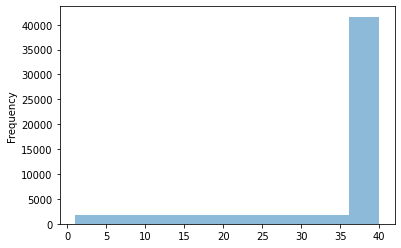

In [8]:
# Show sequences' length
g = df.groupby(["case_id", "track_id"])
c = g.count()
column = c.frame_id
ax = column.plot.hist(bins=10, alpha=0.5)

In [9]:
# Select only same length sequences
df = filter_length(df)


# Full dataset info:
# 5163 episodes (cases)
# 60293 trajectories
# 2034258 rows
# 2 agent types

# Only cars dataset:

# 5163 episodes (cases)
# 58191 trajectories
# 1968886 rows
# 1 agent type

# length filtered dataset:
# 5163 episodes
# 40228 trajectories
# 1609120 rows
# 1 agent type

###############################


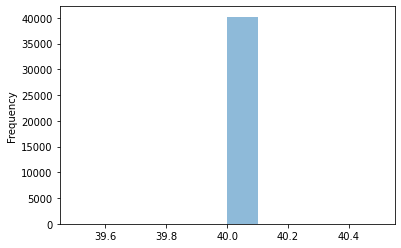

In [10]:
# Show sequences' length
g = df.groupby(["case_id", "track_id"])
c = g.count()
column = c.frame_id
ax = column.plot.hist(bins=10, alpha=0.5)


In [11]:
# Group counts, trajectory lengths
print(c)

                  object_id  frame_id  timestamp_ms  agent_type   x   y  vx  \
case_id track_id                                                              
1.0     1                40        40            40          40  40  40  40   
        2                40        40            40          40  40  40  40   
        4                40        40            40          40  40  40  40   
        5                40        40            40          40  40  40  40   
        6                40        40            40          40  40  40  40   
...                     ...       ...           ...         ...  ..  ..  ..   
5162.0  6                40        40            40          40  40  40  40   
5163.0  2                40        40            40          40  40  40  40   
        3                40        40            40          40  40  40  40   
        4                40        40            40          40  40  40  40   
        5                40        40            40 

In [12]:
print("Only same length trajectories:", len(c))

Only same length trajectories: 40228


In [13]:
df.to_csv('/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/filtered-DR_USA_Intersection_MA_.csv',  index = False)

In [5]:
df = pd.read_csv('/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/filtered-DR_USA_Intersection_MA_.csv', sep=',')

In [14]:
# Split in training and test set

from numpy.random import default_rng
import math


g = df.groupby(["case_id"])
g_count = g.ngroups

training_size = math.floor(g_count/100)*80 # 80% for the training size
test_size = g_count - training_size

rng = default_rng(1)
choice = rng.choice(g.ngroups, training_size, replace=False)


In [15]:
# Create the two data splits

#training = df[g.ngroup().isin(choice)]
#test = df[~g.ngroup().isin(choice)]

g_ngroup = g.ngroup() #assign the group index to each row
training = df[g_ngroup.isin(choice)] # select only training groups
test = df[~g_ngroup.isin(choice)]


In [16]:
training.to_csv('/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/filtered-DR_USA_Intersection_MA_train.csv',  index = False)

In [17]:
test.to_csv('/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/filtered-DR_USA_Intersection_MA_test.csv',  index = False)

In [18]:
print("Full dataset size: ",g_count)

g = training.groupby(["case_id"])
g_count = g.ngroups
print("Training size:", g_count)

g = test.groupby(["case_id"])
g_count = g.ngroups
print("Test size:", g_count)

Full dataset size:  5163
Training size: 4080
Test size: 1083


In [27]:
from time import process_time

# Create clustered dataset for training
start = process_time()
clustered_training = create_clustered_dataset(training, max_radius=50,split="train")
elapsed = (process_time() - start)


MaxDiameterClustering fit: 100%|██████████| 8/8 [00:00<00:00, 3802.63it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 7/7 [00:00<00:00, 4431.72it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 3/3 [00:00<00:00, 2114.78it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 1/1 [00:00<00:00, 1831.57it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 5/5 [00:00<00:00, 2384.21it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 7/7 [00:00<00:00, 3393.84it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 1/1 [00:00<00:00, 2199.43it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 3/3 [00:00<00:00, 2531.26it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|

In [29]:
print(elapsed)

214.03414902300003


In [21]:
from time import process_time
# Create clustered dataset for test
start = process_time()
clustered_test = create_clustered_dataset(test, max_radius=50,split="test")
elapsed = (process_time() - start)


MaxDiameterClustering fit: 100%|██████████| 2/2 [00:00<00:00, 2149.27it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 4/4 [00:00<00:00, 4479.90it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 4/4 [00:00<00:00, 1007.10it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 9/9 [00:00<00:00, 4097.33it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 3/3 [00:00<00:00, 4031.69it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 6/6 [00:00<00:00, 2475.49it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 5/5 [00:00<00:00, 2837.06it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|██████████| 2/2 [00:00<00:00, 3173.90it/s]
MaxDiameterClustering fit: 0it [00:00, ?it/s]
MaxDiameterClustering fit: 100%|

In [22]:
print(elapsed)

53.95393962


In [23]:
def plot_clusters(clustered_df):

    # display parameters
    a4_dims = (15, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.set_palette("pastel")


    # Display how many clusters were created, and its elements
    case_id = clustered_df.groupby(["case_id", "label"])

    g = []

    for ix,element in case_id:
        l = element.groupby(["track_id"])
        g.append(len(l))

    print("max number of cars by cluster: ", max(g))
    print("number of clusters:", len(g)) 

    ax = sns.histplot(ax=ax, data=g, discrete=True, shrink=.8)
    ax.set(xlabel='number of interacting vehicles', ylabel='number of groups')

In [30]:
# Load already pre-computed clustered dataset (TRAIN)
clustered_df_train = pd.read_csv('/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/50m-DR_USA_Intersection_MA_train.csv', sep=',')


In [31]:
# Show number of trajectories length
g = clustered_df_train.groupby(["case_id", "track_id"])
c = g.count()
print("Number of trajectories in train: ",c.shape[0])

Number of trajectories in train:  31778


max number of cars by cluster:  14
number of clusters: 8725


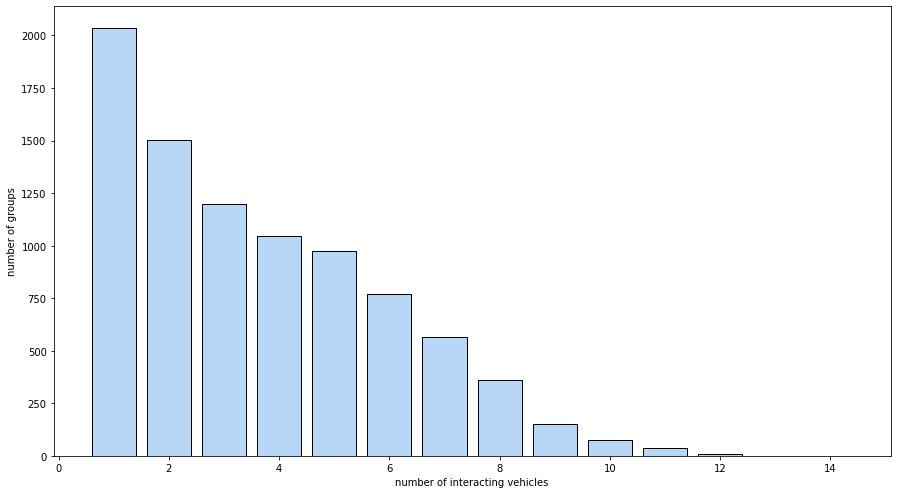

In [32]:
plot_clusters(clustered_df_train)

In [24]:
# Load already pre-computed clustered dataset (TEST)
clustered_df_test = pd.read_csv('/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/50m-DR_USA_Intersection_MA_test.csv', sep=',')


In [25]:
# Show number of trajectories length
g = clustered_df_test.groupby(["case_id", "track_id"])
c = g.count()
print("Number of trajectories in test: ",c.shape[0])

Number of trajectories in test:  8450


max number of cars by cluster:  13
number of clusters: 2349


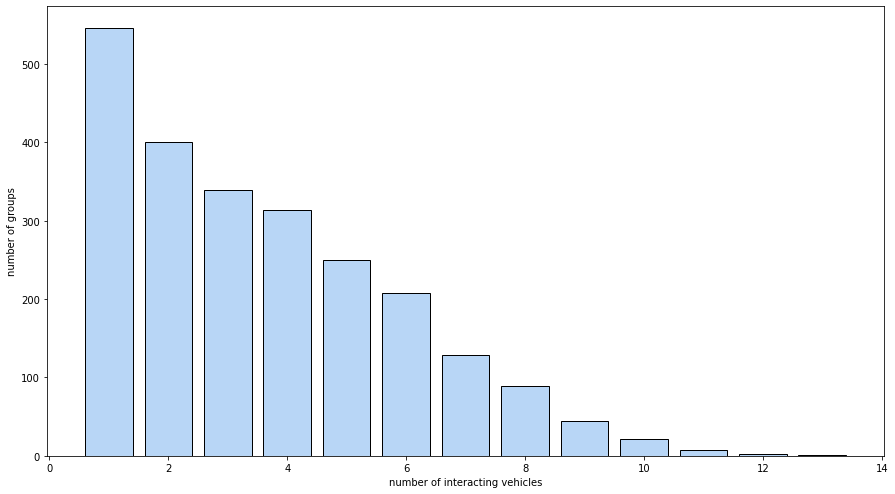

In [26]:
plot_clusters(clustered_df_test)

In [34]:
clustered_df_train.head(5)

,case_id,track_id,label,cluster_id,object_id,frame_id,timestamp_ms,agent_type,x,y,vx,vy,psi_rad,length,width
0,1.0,1,0,0,0,1,100,car,1005.989,999.625,6.367,-0.230,-0.036,4.31,1.48
1,1.0,1,0,0,0,3,300,car,1007.291,999.588,6.930,-0.207,-0.030,4.31,1.48
2,1.0,1,0,0,0,5,500,car,1008.705,999.556,7.473,-0.183,-0.024,4.31,1.48
3,1.0,1,0,0,0,7,700,car,1010.226,999.527,7.988,-0.159,-0.020,4.31,1.48
4,1.0,1,0,0,0,9,900,car,1011.848,999.502,8.467,-0.136,-0.016,4.31,1.48


**FILTER BY NUMBER OF CARS IN CLUSTER**

In [39]:
def create_filtered_dataset(df, max_cars, max_radius,split):

    column_names = list(df.columns)

    filtered = []
    case_id = df.groupby(["case_id", "label"])

    for ix,element in case_id:
        l = element.groupby(["track_id"])
        if(len(l)==max_cars): # number of interacting vehicles
            for iy,e in l:
                filtered.append(e.values.tolist())

    # Convert list results to array
    filtered_array = np.array(filtered)

    filtered_array = filtered_array.reshape(-1,filtered_array.shape[2]) # Remove the dimension added by grouping by case. 15 is the number of features
#    print(filtered_array.shape)
    # Create pandas dataframe from array
#    column_names = ['case_id', 'track_id', 'frame_id', 'timestamp_ms', 'agent_type', 'x','y', 'vx', 'vy', 'psi_rad', 'length', 'width','object_id','label','cluster_id']
 #   column_names = [['case_id', 'track_id', 'label','cluster_id','object_id', 'frame_id', 'timestamp_ms', 'agent_type', 'x','y', 'vx', 'vy', 'psi_rad', 'length', 'width']]
    filtered_df = pd.DataFrame(filtered_array,columns= column_names)
    # Reorder columns
 #   filtered_df = filtered_df[['case_id', 'track_id', 'label','cluster_id','object_id', 'frame_id', 'timestamp_ms', 'agent_type', 'x','y', 'vx', 'vy', 'psi_rad', 'length', 'width']]

    # To ensure that all rows in the .csv are ordered by case_id,label and track_id
    filtered_df = flatten_df_group(filtered_df)

    # Save filtered dataset to file
    filtered_df.to_csv('/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/'+str(max_radius)+'m-'+str(max_cars)+'c-'+'DR_USA_Intersection_MA_'+split+'.csv',  index = False)
   
    #return filtered_df






In [40]:
create_filtered_dataset(clustered_df_train, max_cars = 6, max_radius=50, split="train")

In [41]:
create_filtered_dataset(clustered_df_test, max_cars = 6, max_radius=50, split="test")